In [ ]:
# 我们会做以下几步，每一步都有中文注释和清晰逻辑：
# 	1.	读取数据并合并
# 	2.	特征工程（添加新特征 Title、IsAlone 等）
# 	3.	缺失值处理
# 	4.	编码类别变量
# 	5.	训练 RandomForest 模型
# 	6.	提交文件生成与预测上传

In [1]:
# Titanic 生还预测项目 - 随机森林版本（全新构建）
# 步骤 1：读取并合并数据

import pandas as pd
import numpy as np

# 读取数据
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 保留 PassengerId，后面用于提交
test_passenger_ids = test_df["PassengerId"]

# 添加标记，方便分开训练和测试集
train_df["Dataset"] = "train"
test_df["Dataset"] = "test"
test_df["Survived"] = np.nan  # 填上空值，方便拼接

# 合并处理
full_df = pd.concat([train_df, test_df], ignore_index=True)

print("✅ 数据读取和合并完成")
full_df.head()

✅ 数据读取和合并完成


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [2]:
# 步骤 2：特征工程 - 提取新特征

# 1. 提取 Title（从 Name 中抽取称呼）
full_df["Title"] = full_df["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

# 统一一些稀有称呼
full_df["Title"] = full_df["Title"].replace([
    'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 
    'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
full_df["Title"] = full_df["Title"].replace({
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"
})

# 2. 创建 FamilySize 特征（家庭总人数）
full_df["FamilySize"] = full_df["SibSp"] + full_df["Parch"] + 1

# 3. 是否独自一人
full_df["IsAlone"] = (full_df["FamilySize"] == 1).astype(int)

# 4. 是否有舱位号
full_df["Cabin_known"] = full_df["Cabin"].notnull().astype(int)

print("✅ 新特征提取完成")
full_df[["Name", "Title", "FamilySize", "IsAlone", "Cabin", "Cabin_known"]].head()

✅ 新特征提取完成


,Name,Title,FamilySize,IsAlone,Cabin,Cabin_known
0,"Braund, Mr. Owen Harris",Mr,2,0,NaN,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,2,0,C85,1
2,"Heikkinen, Miss. Laina",Miss,1,1,NaN,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,2,0,C123,1
4,"Allen, Mr. William Henry",Mr,1,1,NaN,0


In [3]:
# 步骤 3：缺失值处理

# Embarked（登船港口）缺失值，用众数填补
full_df["Embarked"] = full_df["Embarked"].fillna(full_df["Embarked"].mode()[0])

# Fare（票价）缺失值，用中位数填补
full_df["Fare"] = full_df["Fare"].fillna(full_df["Fare"].median())

# Age（年龄）缺失值，用每个 Title 的中位数来填补
# ✅ 拆解逐部分解释：
# full_df.groupby("Title")["Age"]
# 这一步是：
#     把数据按照 Title 这个字段分组，然后选中每组的 Age 列。
# 比如：
# 	•	Mr 是一组，包含所有叫 Mr 的人
# 	•	Miss 是一组，包含所有 Miss
# transform(lambda x: x.fillna(x.median()))
# 这个是对每一组做处理（而不是只返回一个聚合值）：
# x.fillna(x.median())：
# 意思是：
#     把当前组（比如所有 Mr）中的空值填成该组的中位数。
# transform(...)：
# transform 会返回和原数据等长的结果，而不像 apply 那样可能压缩成单个值。它允许你将结果**“按原顺序贴回原表格”**。
full_df["Age"] = full_df.groupby("Title")["Age"].transform(lambda x: x.fillna(x.median()))


# 检查是否还有缺失值
	# •	.isnull().sum() 会统计每一列中有多少个缺失值。
	# •	输出结果全是 0 表示所有缺失值已经成功填补 ✅
print("✅ 剩余缺失值统计：")
print(full_df[["Age", "Embarked", "Fare"]].isnull().sum())

✅ 剩余缺失值统计：
Age         0
Embarked    0
Fare        0
dtype: int64


In [4]:
# 步骤 4：类别变量数字化（Label Encoding）

# Sex: male → 0, female → 1
full_df["Sex"] = full_df["Sex"].map({"male": 0, "female": 1})

# Embarked: S/C/Q → 0/1/2
full_df["Embarked"] = full_df["Embarked"].map({"S": 0, "C": 1, "Q": 2})

# Title: 使用分类编码为整数（可选）
title_mapping = {title: idx for idx, title in enumerate(full_df["Title"].unique())}
full_df["Title"] = full_df["Title"].map(title_mapping)

print("✅ 类别变量已转换为数字")
full_df[["Sex", "Embarked", "Title"]].head()

✅ 类别变量已转换为数字


,Sex,Embarked,Title
0,0,0,0
1,1,1,1
2,1,0,2
3,1,0,1
4,0,0,0


In [ ]:
# ✅ 步骤 5：训练 Random Forest 模型并对 test.csv 预测 🎯
# 这是整个建模流程的核心部分，将使用 RandomForestClassifier（随机森林）来训练模型并做出预测。
# 📦 我们会做以下几件事：
# 	1.	从 full_df 中重新拆分训练集和测试集；
# 	2.	选取处理好的特征作为模型输入；
# 	3.	用随机森林训练模型；
# 	4.	对 test.csv 的乘客做预测；
# 	5.	保存预测结果用于提交。

In [5]:
# 步骤 5：准备建模数据并训练 Random Forest 模型

from sklearn.ensemble import RandomForestClassifier

# 重新拆分训练集和测试集
train_final = full_df[full_df["Dataset"] == "train"]
test_final = full_df[full_df["Dataset"] == "test"]

# 特征选择（你可以再加入其他特征试试）
features = ["Pclass", "Sex", "Age", "Fare", "Embarked", "Title", "FamilySize", "IsAlone", "Cabin_known"]

X_train = train_final[features]
y_train = train_final["Survived"].astype(int)  # 转为整数
X_test = test_final[features]

# 创建随机森林模型并训练
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("✅ 模型训练完成")

✅ 模型训练完成


In [6]:
# 步骤 6：预测 test 数据并生成提交文件

# 用训练好的模型进行预测
test_preds = rf_model.predict(X_test)

# 创建提交文件 DataFrame
submission = pd.DataFrame({
    "PassengerId": test_passenger_ids,  # 原始 test_df 中的 ID
    "Survived": test_preds.astype(int)  # 转为 int 类型，避免 0.0 / 1.0 的错误
})

# 保存为 CSV 文件
submission.to_csv("submission.csv", index=False)

print("✅ 已生成 submission.csv，可上传到 Kaggle 提交预测！")

✅ 已生成 submission.csv，可上传到 Kaggle 提交预测！


In [ ]:
# ✅ 优化路线 1：模型调参（使用 GridSearchCV 优化 RandomForest）

In [7]:
# 路线 1：模型调参 - 使用 GridSearchCV 优化随机森林

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# 定义参数网格
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt']
}

# 初始化模型
rf = RandomForestClassifier(random_state=42)

# 初始化 GridSearchCV（使用5折交叉验证）
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# 开始搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数和得分
print("✅ 最佳参数：", grid_search.best_params_)
print("📈 最佳交叉验证得分：", grid_search.best_score_)

# 用最佳模型进行预测
best_rf = grid_search.best_estimator_
test_preds = best_rf.predict(X_test)

# 保存提交文件
submission = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": test_preds.astype(int)
})
submission.to_csv("submission_rf_tuned.csv", index=False)

print("✅ 已生成调参后的提交文件 submission_rf_tuned.csv")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ 最佳参数： {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
📈 最佳交叉验证得分： 0.8338647919151342
✅ 已生成调参后的提交文件 submission_rf_tuned.csv


/Users/efficient/.pyenv/versions/dl_macos_m4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/efficient/.pyenv/versions/dl_macos_m4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/efficient/.pyenv/versions/dl_macos_m4/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/efficient/.pyenv/versions/dl_macos_m4/lib/python3.10/site-packages/sklearn/

/var/folders/gv/0y8vc5r940qdlj4pbpb4lzhw0000gn/T/ipykernel_19239/991016850.py:17: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gv/0y8vc5r940qdlj4pbpb4lzhw0000gn/T/ipykernel_19239/991016850.py:17: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gv/0y8vc5r940qdlj4pbpb4lzhw0000gn/T/ipykernel_19239/991016850.py:17: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gv/0y8vc5r940qdlj4pbpb4lzhw0000gn/T/ipykernel_19239/991016850.py:17: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gv/0y8vc5r940qdlj4pbpb4lzhw0000gn/T/ipykernel_19239/991016850.py:17: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gv/0y8vc5r940qdlj4pbpb4

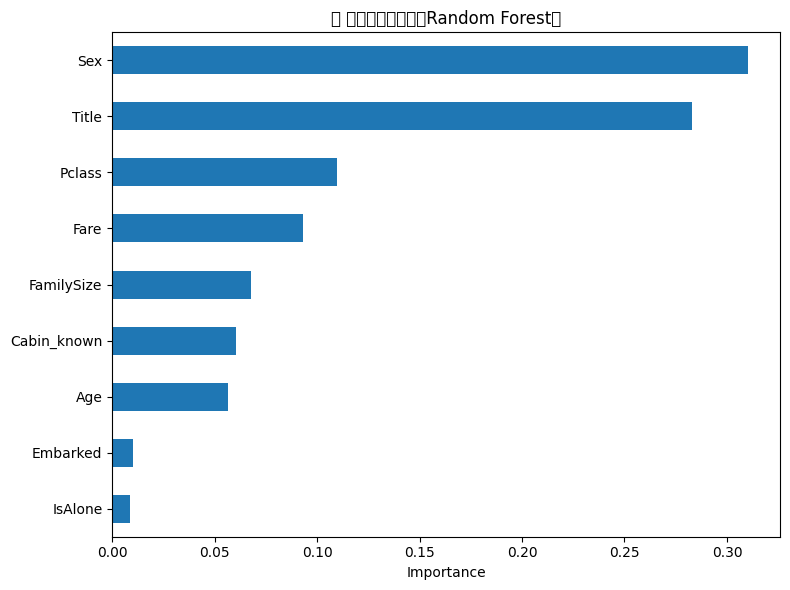

In [8]:
# 优化路线 2 - 步骤 A：查看随机森林模型的特征重要性

import matplotlib.pyplot as plt

# 特征重要性
importances = best_rf.feature_importances_
feature_names = X_train.columns

# 排序
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# 绘图
plt.figure(figsize=(8, 6))
feat_imp.plot(kind='barh')
plt.title("🌲 特征重要性排序（Random Forest）")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [9]:
# 优化路线2步骤 B：移除弱特征后重新训练模型

# 重新定义特征集合（去掉 Embarked 和 IsAlone）
selected_features = ["Pclass", "Sex", "Age", "Fare", "Title", "FamilySize", "Cabin_known"]

# 构造训练和测试数据
X_train_opt = train_final[selected_features]
X_test_opt = test_final[selected_features]

# 用之前调好的最优参数训练新的模型
optimized_rf = RandomForestClassifier(
    n_estimators=grid_search.best_params_["n_estimators"],
    max_depth=grid_search.best_params_["max_depth"],
    min_samples_split=grid_search.best_params_["min_samples_split"],
    max_features=grid_search.best_params_["max_features"],
    random_state=42
)
optimized_rf.fit(X_train_opt, y_train)

# 预测并保存结果
test_preds_opt = optimized_rf.predict(X_test_opt)
submission_opt = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": test_preds_opt.astype(int)
})
submission_opt.to_csv("submission_rf_features_optimized.csv", index=False)

print("✅ 特征精简后提交文件已生成：submission_rf_features_optimized.csv")

✅ 特征精简后提交文件已生成：submission_rf_features_optimized.csv


In [12]:
# 路线2 Step C：添加 AgeGroup 分箱特征

def get_age_group(age):
    if age <= 12:
        return 0  # child
    elif age <= 18:
        return 1  # teen
    elif age <= 35:
        return 2  # adult
    elif age <= 60:
        return 3  # mid_age
    else:
        return 4  # senior

# 应用分组函数
full_df["AgeGroup"] = full_df["Age"].apply(get_age_group)

print("✅ Age 分组完成，新增特征 AgeGroup")
full_df[["Age", "AgeGroup"]].head(10)

✅ Age 分组完成，新增特征 AgeGroup


,Age,AgeGroup
0,22.0,2
1,38.0,3
2,26.0,2
3,35.0,2
4,35.0,2
5,29.0,2
6,54.0,3
7,2.0,0
8,27.0,2
9,14.0,1


In [13]:
# 路线2 Step C：提取 Ticket 的字母前缀

def extract_ticket_prefix(ticket):
    ticket = ticket.replace(".", "").replace("/", "")
    parts = ticket.split()
    if len(parts) > 1:
        return parts[0]
    else:
        return "None"

full_df["TicketPrefix"] = full_df["Ticket"].apply(extract_ticket_prefix)

# 显示前缀种类及频次
print("🎟️ Ticket 前缀类别统计：")
print(full_df["TicketPrefix"].value_counts())

# Label Encoding：将票号前缀映射为整数
prefix_mapping = {prefix: idx for idx, prefix in enumerate(full_df["TicketPrefix"].unique())}
full_df["TicketPrefix"] = full_df["TicketPrefix"].map(prefix_mapping)

print("✅ TicketPrefix 映射完成")

🎟️ Ticket 前缀类别统计：
TicketPrefix
None       961
PC          92
CA          68
A5          28
SOTONOQ     24
WC          15
SCPARIS     14
STONO       14
A4          10
FCC          9
C            8
SOC          8
SOPP         7
STONO2       7
SCParis      5
SCAH         5
WEP          4
PP           4
FC           3
SOTONO2      3
SWPP         2
PPP          2
SC           2
SCA4         2
SCA3         1
A            1
LP           1
AQ4          1
STONOQ       1
Fa           1
CASOTON      1
AS           1
SCOW         1
SOP          1
SP           1
AQ3          1
Name: count, dtype: int64
✅ TicketPrefix 映射完成


In [15]:
# 更新划分
train_final = full_df[full_df["Dataset"] == "train"]
test_final = full_df[full_df["Dataset"] == "test"]

# 新特征集
selected_features = ["Pclass", "Sex", "Fare", "Title", "FamilySize", "Cabin_known", "AgeGroup", "TicketPrefix"]
X_train_plus = train_final[selected_features]
X_test_plus = test_final[selected_features]
y_train = train_final["Survived"].astype(int)

# 使用调优参数训练模型
rf_ticket = RandomForestClassifier(
    n_estimators=grid_search.best_params_["n_estimators"],
    max_depth=grid_search.best_params_["max_depth"],
    min_samples_split=grid_search.best_params_["min_samples_split"],
    max_features=grid_search.best_params_["max_features"],
    random_state=42
)
rf_ticket.fit(X_train_plus, y_train)

# 预测并保存
test_preds_plus = rf_ticket.predict(X_test_plus)
submission_ticket = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": test_preds_plus.astype(int)
})
submission_ticket.to_csv("submission_rf_with_ticketprefix.csv", index=False)

print("✅ 加入 TicketPrefix 后的提交文件已生成：submission_rf_with_ticketprefix.csv")

✅ 加入 TicketPrefix 后的提交文件已生成：submission_rf_with_ticketprefix.csv


In [18]:
# 优化路线 3：模型融合 VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# 定义各个子模型（可根据之前调优参数）
log_clf = LogisticRegression(max_iter=200)
rf_clf = RandomForestClassifier(
    n_estimators=grid_search.best_params_["n_estimators"],
    max_depth=grid_search.best_params_["max_depth"],
    min_samples_split=grid_search.best_params_["min_samples_split"],
    max_features=grid_search.best_params_["max_features"],
    random_state=42
)
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric="logloss"
)
# 构建投票模型（硬投票：多数决定）
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rf_clf), ('xgb', xgb_clf)],
    voting='soft'
)

# 使用前面优化过的特征
X_train_final = train_final[selected_features]
X_test_final = test_final[selected_features]
y_train = train_final["Survived"].astype(int)

# 训练融合模型
voting_clf.fit(X_train_final, y_train)

# 预测并保存
final_preds = voting_clf.predict(X_test_final)
submission_ensemble = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": final_preds.astype(int)
})
submission_ensemble.to_csv("submission_voting_ensemble.csv", index=False)

print("✅ 模型融合提交文件已生成：submission_voting_ensemble.csv")

✅ 模型融合提交文件已生成：submission_voting_ensemble.csv


In [19]:
# 移除表现一般的 LogisticRegression，只保留表现稳定、得分更高的 RF + XGB 组合进行硬投票。
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

# 使用 RandomForest 和 XGBoost 进行投票融合
rf_clf = RandomForestClassifier(
    n_estimators=grid_search.best_params_["n_estimators"],
    max_depth=grid_search.best_params_["max_depth"],
    min_samples_split=grid_search.best_params_["min_samples_split"],
    max_features=grid_search.best_params_["max_features"],
    random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric="logloss"
)

# VotingClassifier 融合两个强模型
voting_strong = VotingClassifier(
    estimators=[('rf', rf_clf), ('xgb', xgb_clf)],
    voting='hard'
)

# 拟合模型
voting_strong.fit(X_train_final, y_train)

# 生成预测并保存
preds_strong = voting_strong.predict(X_test_final)
submission_strong = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": preds_strong.astype(int)
})
submission_strong.to_csv("submission_voting_rf_xgb.csv", index=False)

print("✅ RF + XGB 融合提交文件已生成：submission_voting_rf_xgb.csv")

✅ RF + XGB 融合提交文件已生成：submission_voting_rf_xgb.csv


In [20]:
# ✅ 方案 C：模型融合进阶 —— Stacking 模型构建
# 🎯 什么是 Stacking？
# Stacking（堆叠泛化）是一种更聪明的模型融合方式：
# 	•	多个基础模型（Level 0）先进行预测；
# 	•	再用一个元模型（Level 1）来“学习”如何组合这些预测；
# 	•	效果通常优于简单 Voting。

# 构建：
# •	Level 0：RandomForest + XGBoost + Logistic
# •	Level 1：Logistic Regression（元模型）

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Level 0 模型（基础模型）
level0_models = [
    ('rf', RandomForestClassifier(
        n_estimators=grid_search.best_params_["n_estimators"],
        max_depth=grid_search.best_params_["max_depth"],
        min_samples_split=grid_search.best_params_["min_samples_split"],
        max_features=grid_search.best_params_["max_features"],
        random_state=42
    )),
    ('xgb', XGBClassifier(
        n_estimators=100, max_depth=4, learning_rate=0.1,
        eval_metric="logloss"
    )),
    ('lr', LogisticRegression(max_iter=200))
]

# Level 1 元模型
meta_model = LogisticRegression()

# 构建 StackingClassifier
stacking_clf = StackingClassifier(
    estimators=level0_models,
    final_estimator=meta_model,
    passthrough=False,  # True 会将原始特征也一起传入 meta_model
    cv=5,
    n_jobs=-1
)

# 训练 Stacking 模型
stacking_clf.fit(X_train_final, y_train)

# 预测并保存
preds_stack = stacking_clf.predict(X_test_final)
submission_stack = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": preds_stack.astype(int)
})
submission_stack.to_csv("submission_stacking_ensemble.csv", index=False)

print("✅ Stacking 模型融合提交文件已生成：submission_stacking_ensemble.csv")

✅ Stacking 模型融合提交文件已生成：submission_stacking_ensemble.csv
